In [1]:
from fastai.imports import *

/home/jazari/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [27]:
PATH = 'data/dogscats/'

In [28]:
sz = 224

In [29]:
!ls {PATH}

models	sample	test1  tmp  train  valid


In [30]:
!ls {PATH}/valid

cats  dogs


In [31]:
files = !ls {PATH}/valid/cats | head
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

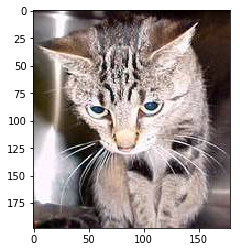

In [32]:
img = plt.imread(f'{PATH}/valid/cats/{files[0]}')
plt.imshow(img)

In [33]:
img.shape

(198, 179, 3)

In [34]:
img[:4, :4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

In [35]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy                      
    0      0.046591   0.028251   0.989     
    1      0.03885    0.029529   0.99                          
    2      0.040581   0.026137   0.9905                        



[array([0.02614]), 0.9905]

In [36]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [37]:
data.classes

['cats', 'dogs']

In [38]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [39]:
log_preds[:10]

array([[ -0.01763,  -4.04687],
       [ -0.00001, -11.50874],
       [ -0.     , -13.03843],
       [ -0.00014,  -8.83786],
       [ -0.00033,  -8.00935],
       [ -0.00541,  -5.22241],
       [ -0.01459,  -4.235  ],
       [ -0.00015,  -8.79521],
       [ -0.00058,  -7.45761],
       [ -0.00004, -10.12638]], dtype=float32)

In [40]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])
probs

array([0.01748, 0.00001, 0.     , ..., 0.99974, 0.99985, 0.99482], dtype=float32)

In [41]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [42]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [43]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified dogs


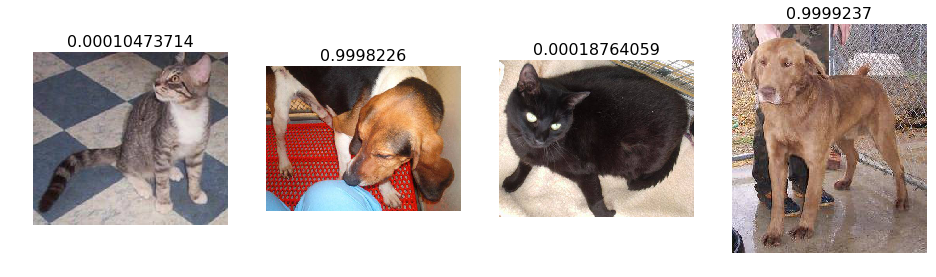

In [44]:
plot_val_with_title(rand_by_correct(True), "Correctly classified dogs")

Incorrectly classified Dogs


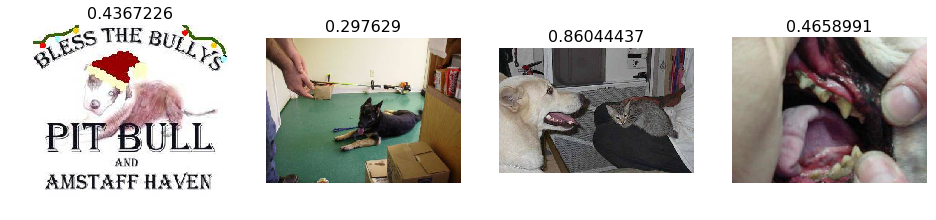

In [45]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified Dogs")

In [47]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most Correct Dogs


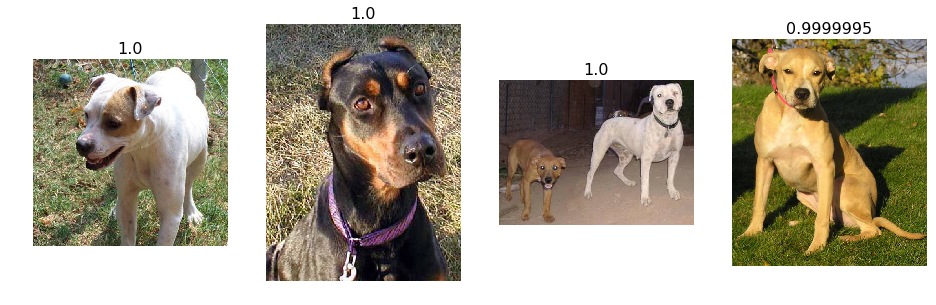

In [48]:
plot_val_with_title(most_by_correct(1, True), "Most Correct Dogs")

Most Correct Cats


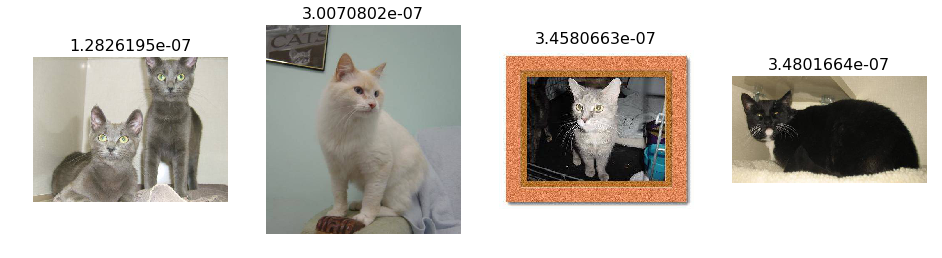

In [49]:
plot_val_with_title(most_by_correct(0, True), "Most Correct Cats")

Most incorrect cats


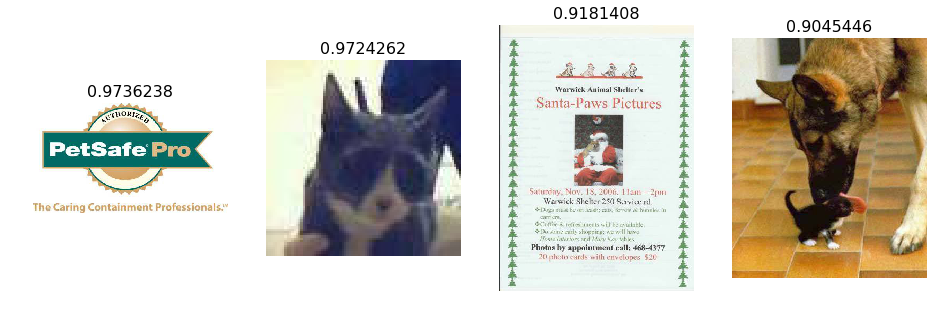

In [50]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


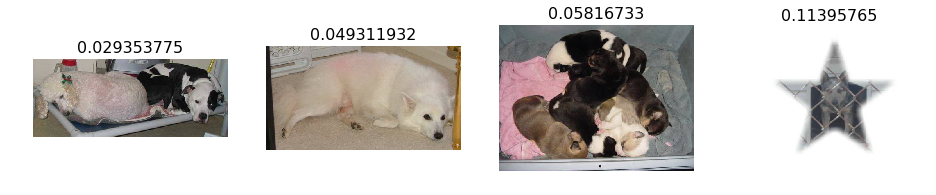

In [51]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


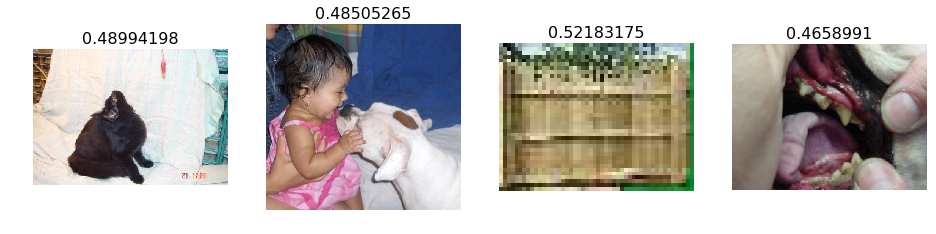

In [52]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [ ]:
f